In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from torchvision import datasets, transforms
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.cuda as cuda
import torch

In [2]:
use_gpu = cuda.is_available()

# Learning to generate MNIST digits using a De-Convolutional Generator Discriminator model

In [3]:
class Generator(nn.Module):
    def __init__(self, n_channels=100, reuse=False ):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #1st hidden layer
            nn.ConvTranspose2d(in_channels=n_channels, #"Deconvolutional" layer 
                               out_channels=1024,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(1024, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #2nd hidden layer
            nn.ConvTranspose2d(in_channels=1024,
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=2,
                               bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #3rd hidden layer
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #4th hidden layer
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=2,
                               bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            # output layer
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        output = self.main(x)
        return output

In [4]:
class Discriminator(nn.Module):
    def __init__(self, reuse=False, n_channels=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #1st hidden layer
            nn.Conv2d(in_channels=n_channels,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            
            #2nd hidden layer
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=2,
                      bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            
            #3rd hidden layer
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            
            #4th hidden layer
            nn.Conv2d(in_channels=512,
                      out_channels=1024,
                      kernel_size=4,
                      stride=2,
                      padding=2,
                      bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.2),
            
            #output layer
            nn.Conv2d(in_channels=1024,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.Sigmoid()
            
        )
    def forward(self, y):
        output = self.main(y)
        return output
        

In [40]:
# define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform, )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=1 )

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=1 )

classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

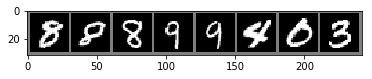

    8     8     8     9     9     4     0     3


In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
#     Permute the axes 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
images, labels = images[0:8], labels[0:8]
imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s" % classes[labels[j]] for j in range(len(labels))))